In [227]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

In [228]:
def extract_middle_roi(image, target_width, offset_X, offset_Y):
    """
    Extract the middle region of an image with a specified target width.

    Args:
        image (numpy.ndarray): Input image.
        target_width (int): Desired width of the extracted region.

    Returns:
        numpy.ndarray: Extracted middle region of the image.
    """
    height, width = image.shape[:2]
    aspect_ratio = width / height
    target_height = int(target_width / aspect_ratio)
    x = int((width - target_width) / 2) + offset_X
    y = int((height - target_height) / 2) + offset_Y
    x2 = x + target_width 
    y2 = y + target_height 
    middle_roi = image[y:y2, x:x2]
    return middle_roi

In [229]:
def preprocess_image(image_path, threshold_val=0):
    """
    Preprocess an image by cropping and thresholding.

    Args:
        image_path (str): Path to the input grayscale image.
        threshold_val (int, optional): Threshold value for image thresholding.

    Returns:
        tuple: Tuple containing threshold value and path to the preprocessed image.
    """
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crop image
    image = extract_middle_roi(image, 1500)

    if threshold_val == 0:
        threshold_val = 5
        # Find threshold with sd
        for x in range(5, 10):
            mask = np.where(image < x, 1, 0)
            masked_intensities = image[mask == 1]
            mean_intensity = np.mean(masked_intensities)
            sd_intensity = np.std(masked_intensities)
            two_sd = (mean_intensity + (2 * sd_intensity))
            three_sd = (mean_intensity + (3 * sd_intensity))
            print("current threshold: {}".format(x))
            print("two_sd: {}".format(two_sd))
            print("three_sd: {}".format(three_sd))

            if x >= two_sd and x <= three_sd:
                threshold_val = x
                break

    # Filter out pixels with intensities below the threshold_val
    _, image_filtered = cv2.threshold(image, threshold_val, 255, cv2.THRESH_TOZERO)

    print("Threshold value:", threshold_val)

    # Save and download to local disk
    # Extract the filename from the original image path
    filename = image_path.split("/")[-1]

    # Create the new path by concatenating the desired directory and the filename
    new_path = os.path.dirname(image_path) + "/thresholded/"

    # Create the folder if it doesn't exist
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    new_path += filename

    cv2.imwrite(new_path, image_filtered)

    print("Saved thresholded image to: {}".format(new_path))

    return threshold_val, new_path

In [230]:
def sum_contour(contour, image):
    sum = 0
    mask = np.zeros_like(image)
    
    for dot in contour:
        #print([dot[0][0], "   ", dot[0][1]])
        sum = sum + image[dot[0][1], dot[0][0]]
    return sum

In [243]:
def RGB_mask(image_path, output_path, threshold_val, offsetX, offsetY):
    """
    Preprocess an image by cropping and thresholding.

    Args:
        image_path (str): Path to the input grayscale image.
        threshold_val (int, optional): Threshold value for image thresholding.

    Returns:
        tuple: Tuple containing threshold value and path to the preprocessed image.
    """

    df = pd.DataFrame(columns=['id', 'x', 'y', 'area', 'perimeter', 'total_signal'])

    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crop image
    image = extract_middle_roi(image, 1500, offsetX, offsetY)
 
    # Filter out pixels with intensities below the threshold_val
    _, image_filtered = cv2.threshold(image, threshold_val, 255, cv2.THRESH_TOZERO)


    binary_image = np.where(image_filtered > 0,100,0)
    cv2.imwrite("binary.jpg", binary_image)


    print("Threshold value:", threshold_val)

    # Save and download to local disk
    # Extract the filename from the original image path
    filename = image_path.split("/")[-1]

    # Create the new path by concatenating the desired directory and the filename
    new_path = os.path.dirname(image_path) + "/thresholded/"

    # Create the folder if it doesn't exist
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    for row in range(image_filtered.shape[0]):
        for col in range(image_filtered.shape[1]):
            pixel_value = image_filtered[row, col]
            if pixel_value > 0:
                pass
                #image_filtered[row,col]=255
        

       # if (image[row, col] != 0 and blue_img[row,col]==0):
        #    pixel_value = image[row, col]
         #   blue_pixel_value = blue_img[row, col]
          #  print(f'Pixel at ({row}, {col}): {pixel_value}')
           # print(f'Blue Pixel at ({row}, {col}): {blue_pixel_value}')
            #image[row,col]=0

    contours, _ = cv2.findContours(image_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    # Create a copy of the original image
    image_with_rectangles = np.copy(image_filtered)

    
    threshold_area = 100

    id = 0
    for i in range(0, len(contours)):
        contour = contours[i]
    #for contour in contours:
        area = cv2.contourArea(contour)    
             
        if area > threshold_area:  
            filtered_contours.append(contour)
            x, y, w, h = cv2.boundingRect(contour)
            #cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (155), 1)  # Adjust color and thickness as needed
            cv2.drawContours(image_with_rectangles, [contour], -1, 100, 1)

            M = cv2.moments(contour)
            area = M["m00"]
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # Perimeter
            perimeter = cv2.arcLength(contour, True)
            centroid = [cX, cY]
            cv2.circle(image_with_rectangles, (cX, cY), 0, (0), -1)
            cv2.putText(image_with_rectangles, str(id), (cX - 2, cY - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)
            

            signal = sum_contour(contour, image)
            df.loc[len(df.index)] = [id, cX, cY, area, perimeter, signal]
            print("ID :", id)
            id = id + 1
    


                
    #Check the images with bounding rectangles
    cv2.imwrite(output_path, image_with_rectangles)
    




    new_path += filename

    cv2.imwrite(new_path, image_filtered)
    

    print("Saved thresholded image to: {}".format(new_path))

    return threshold_val, new_path, filtered_contours, df, binary_image

In [244]:
def apply_mask(original_image, contours, output_image, offset_X, offset_Y):
    clear_image = cv2.imread(original_image, cv2.IMREAD_GRAYSCALE)
    clear_image = extract_middle_roi(clear_image, 1500, offset_X, offset_Y)
    mask_image = np.zeros(clear_image.shape)
    for i in range(0, len(contours)): 
        # contour = contours[i]
        cv2.drawContours(mask_image, contours, i, color=1, thickness=-1)
        cv2.imwrite(output_image, clear_image * mask_image)
 

In [245]:
def read_and_filter_image(image_path, output_path, threshold=8):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = extract_middle_roi(image, 1500)
    _, image_filtered = cv2.threshold(image, threshold, 255, cv2.THRESH_TOZERO)
    cv2.imwrite(output_path, image_filtered)
    

In [246]:
def mean_contour_pixel_diff(image1_path, image2_path, num_of_contour):
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    diff = cv2.absdiff(image1, image2)
    count = (np.count_nonzero(image1 > 0) + np.count_nonzero(image2 > 0)) / 2
    return cv2.sumElems(diff)[0] / count


In [247]:
def sum_contour(contour, image):
    sum = 0
    mask = np.zeros_like(image)
    
    for dot in contour:
        #print([dot[0][0], "   ", dot[0][1]])
        sum = sum + image[dot[0][1], dot[0][0]]
    return sum

In [248]:
def signal_sum(image, array):
    sum = 0
    for point in array:
        sum = sum + image[point[0]][point[1]]
    return sum

In [249]:
def get_signal_mapping(image, mapping):
    new_map = {}
    for key in mapping:
        new_map[key] = signal_sum(image, mapping[key])
    return new_map

In [250]:
def read_and_extract_roi(path, offset_X, offset_Y):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Crop image
    image = extract_middle_roi(image, 1500, offset_X, offset_Y)
    cv2.imwrite(path + '_roi.jpg', image)
    return image

In [251]:
def generate_mapping(contours, image):
    covered_pixels_mapping = {}
    for i in range(0, len(contours)): 
        contour = contours[i]
        mask_image_1 = np.zeros(image.shape)
        cv2.drawContours(mask_image_1, contours, i, color=1, thickness=-1)
        covered_pixels_mapping[i] = np.argwhere(mask_image_1 > 0)
            #print([dot[0][0], "   ", dot[0][1]])
            #image[dot[0][1], dot[0][0]] = 255
    return covered_pixels_mapping
    

## Get contours from blue 16 image.

In [253]:
blue_ima_path = '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/16_16_16_Z_21000000.bmp'
a, b, contours, df, binary = RGB_mask(blue_ima_path,'/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/contour.jpg', 8, -2100, -200)

Threshold value: 8
ID : 0
ID : 1
ID : 2
ID : 3
ID : 4
ID : 5
ID : 6
ID : 7
ID : 8
ID : 9
ID : 10
ID : 11
ID : 12
ID : 13
ID : 14
ID : 15
ID : 16
ID : 17
ID : 18
ID : 19
ID : 20
ID : 21
ID : 22
ID : 23
ID : 24
ID : 25
ID : 26
ID : 27
ID : 28
ID : 29
ID : 30
ID : 31
ID : 32
ID : 33
ID : 34
ID : 35
ID : 36
ID : 37
ID : 38
ID : 39
ID : 40
ID : 41
ID : 42
ID : 43
ID : 44
ID : 45
ID : 46
ID : 47
ID : 48
ID : 49
ID : 50
ID : 51
ID : 52
ID : 53
ID : 54
ID : 55
ID : 56
ID : 57
ID : 58
ID : 59
ID : 60
ID : 61
ID : 62
ID : 63
ID : 64
ID : 65
ID : 66
ID : 67
ID : 68
ID : 69
ID : 70
ID : 71
ID : 72
ID : 73
ID : 74
ID : 75
ID : 76
ID : 77
ID : 78
ID : 79
ID : 80
ID : 81
ID : 82
ID : 83
ID : 84
ID : 85
ID : 86
ID : 87
ID : 88
ID : 89
ID : 90
ID : 91
ID : 92
ID : 93
ID : 94
ID : 95
ID : 96
ID : 97
ID : 98
ID : 99
ID : 100
ID : 101
ID : 102
ID : 103
ID : 104
ID : 105
ID : 106
ID : 107
ID : 108
ID : 109
ID : 110
ID : 111
ID : 112
ID : 113
ID : 114
ID : 115
ID : 116
ID : 117
ID : 118
ID : 119
ID : 120
ID

In [254]:
df

,id,x,y,area,perimeter,total_signal
0,0.0,90.0,1108.0,211.5,55.213203,285.0
1,1.0,42.0,1108.0,219.5,56.041630,240.0
2,2.0,474.0,1106.0,184.5,51.213203,234.0
3,3.0,426.0,1106.0,196.5,53.213203,276.0
4,4.0,378.0,1106.0,206.5,54.041630,227.0
...,...,...,...,...,...,...
1435,1435.0,230.0,4.0,138.5,47.556349,172.0
1436,1436.0,181.0,4.0,136.0,46.142135,141.0
1437,1437.0,133.0,4.0,145.5,47.556349,207.0
1438,1438.0,85.0,4.0,150.0,48.142135,187.0


In [255]:
df_sorted = df.sort_values(by=['x', 'y'])

## Read all Clear Images

In [256]:
clear_image_4 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/4_4_4_clear_200000000.bmp', -2100, -200)
clear_image_8 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/8_8_8_clear_70000000.bmp', -2100, -200)
clear_image_16 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/16_16_16_clear_16000000.bmp', -2100, -200)
clear_image_32 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/32_32_32_clear_4000000.bmp', -2100, -200)
clear_image_64 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/64_64_64_clear_700000.bmp', -2100, -200)
clear_image_128 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/128_128_128_clear_180000.bmp', -2100, -200)
clear_image_255 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/255_255_255_clear_30000.bmp', -2100, -200)

## Read all Blue Images

In [257]:
blue_image_4 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/4_4_4_Z_300000000.bmp', -2100, -200)
blue_image_8 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/8_8_8_Z_110000000.bmp', -2100, -200)
blue_image_16 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/16_16_16_Z_21000000.bmp', -2100, -200)
blue_image_32 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/32_32_32_Z_6500000.bmp', -2100, -200)
blue_image_64 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/64_64_64_Z_1100000.bmp', -2100, -200)
blue_image_128 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/128_128_128_Z_200000.bmp', -2100, -200)
blue_image_255 = read_and_extract_roi('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/255_255_255_Z_40000.bmp', -2100, -200)

## Gennerate mapping.

In [258]:
covered_pixels_mapping = generate_mapping(contours, blue_image_255)

## Filter Blue Images

In [259]:
##read_and_filter_image('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/255_255_255_Z_40000.bmp', '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/filtered_255_Z.jpg', -2100, -200)
##read_and_filter_image('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/128_128_128_Z_200000.bmp', '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/filtered_128_Z.jpg', -2100, -200)
##read_and_filter_image('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/64_64_64_Z_1100000.bmp', '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/filtered_64_Z.jpg', -2100, -200)
##read_and_filter_image('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/32_32_32_Z_6500000.bmp', '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/filtered_32_Z.jpg', -2100, -200)
##read_and_filter_image('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/16_16_16_Z_21000000.bmp', '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/filtered_16_Z.jpg', -2100, -200)
##read_and_filter_image('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/8_8_8_Z_110000000.bmp', '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/filtered_8_Z.jpg', -2100, -200)
##read_and_filter_image('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/4_4_4_Z_300000000.bmp', '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/filtered_4_Z.jpg', -2100, -200)

## Generate Masked Blue Images from Clear Images

In [260]:
apply_mask('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/4_4_4_clear_200000000.bmp', contours, '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/masked_4.jpg', -2100, -200)
apply_mask('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/8_8_8_clear_70000000.bmp', contours, '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/masked_8.jpg', -2100, -200)
apply_mask('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/16_16_16_clear_16000000.bmp', contours, '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/masked_16.jpg', -2100, -200)
apply_mask('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/32_32_32_clear_4000000.bmp', contours, '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/masked_32.jpg', -2100, -200)
apply_mask('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/64_64_64_clear_700000.bmp', contours, '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/masked_64.jpg', -2100, -200)
apply_mask('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/128_128_128_clear_180000.bmp', contours, '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/masked_128.jpg', -2100, -200)
apply_mask('/Users/codyyu/Desktop/leakage_data_WHITE_TEST/255_255_255_clear_30000.bmp', contours, '/Users/codyyu/Desktop/leakage_data_WHITE_TEST/output/masked_255.jpg', -2100, -200)


## Generate signal mappings.

In [261]:
signal_map_4 = get_signal_mapping(clear_image_4, covered_pixels_mapping)
signal_map_8 = get_signal_mapping(clear_image_8, covered_pixels_mapping)
signal_map_16 = get_signal_mapping(clear_image_16, covered_pixels_mapping)
signal_map_32 = get_signal_mapping(clear_image_32, covered_pixels_mapping)
signal_map_64 = get_signal_mapping(clear_image_64, covered_pixels_mapping)
signal_map_128 = get_signal_mapping(clear_image_128, covered_pixels_mapping)
signal_map_255 = get_signal_mapping(clear_image_255, covered_pixels_mapping)

In [262]:
signal_map_ground_truth_4 = get_signal_mapping(blue_image_4, covered_pixels_mapping)
signal_map_ground_truth_8 = get_signal_mapping(blue_image_8, covered_pixels_mapping)
signal_map_ground_truth_16 = get_signal_mapping(blue_image_16, covered_pixels_mapping)
signal_map_ground_truth_32 = get_signal_mapping(blue_image_32, covered_pixels_mapping)
signal_map_ground_truth_64 = get_signal_mapping(blue_image_64, covered_pixels_mapping)
signal_map_ground_truth_128 = get_signal_mapping(blue_image_128, covered_pixels_mapping)
signal_map_ground_truth_255 = get_signal_mapping(blue_image_255, covered_pixels_mapping)

In [263]:
dff = pd.DataFrame()

In [264]:
dff["4_ground_truth_mapping"] = signal_map_ground_truth_4.values()
dff["8_ground_truth_mapping"] = signal_map_ground_truth_8.values()
dff["16_ground_truth_mapping"] = signal_map_ground_truth_16.values()
dff["32_ground_truth_mapping"] = signal_map_ground_truth_32.values()
dff["64_ground_truth_mapping"] = signal_map_ground_truth_64.values()
dff["128_ground_truth_mapping"] = signal_map_ground_truth_128.values()
dff["255_ground_truth_mapping"] = signal_map_ground_truth_255.values()

In [265]:
dff["4_mapping"] = signal_map_4.values()
dff["8_mapping"] = signal_map_8.values()
dff["16_mapping"] = signal_map_16.values()
dff["32_mapping"] = signal_map_32.values()
dff["64_mapping"] = signal_map_64.values()
dff["128_mapping"] = signal_map_128.values()
dff["255_mapping"] = signal_map_255.values()

In [266]:
dff["4_diff"] = dff["4_ground_truth_mapping"] - dff["4_mapping"]
dff["8_diff"] = dff["8_ground_truth_mapping"] - dff["8_mapping"]
dff["16_diff"] = dff["16_ground_truth_mapping"] - dff["16_mapping"]
dff["32_diff"] = dff["32_ground_truth_mapping"] - dff["32_mapping"]
dff["64_diff"] = dff["64_ground_truth_mapping"] - dff["64_mapping"]
dff["128_diff"] = dff["128_ground_truth_mapping"] - dff["128_mapping"]
dff["255_diff"] = dff["255_ground_truth_mapping"] - dff["255_mapping"]


In [267]:
dff["4_to_gt_ratio"] = dff["4_mapping"] / dff["4_ground_truth_mapping"]
dff["8_to_gt_ratio"] = dff["8_mapping"] / dff["8_ground_truth_mapping"] 
dff["16_to_gt_ratio"] = dff["16_mapping"] / dff["16_ground_truth_mapping"]
dff["32_to_gt_ratio"] = dff["32_mapping"] / dff["32_ground_truth_mapping"]
dff["64_to_gt_ratio"] = dff["64_mapping"] / dff["64_ground_truth_mapping"]
dff["128_to_gt_ratio"] = dff["128_mapping"] / dff["128_ground_truth_mapping"]
dff["255_to_gt_ratio"] = dff["255_mapping"] / dff["255_ground_truth_mapping"]

In [268]:
dff["4_diff_percentage"] = ((dff['4_to_gt_ratio'].mean() - 1) * 100)
dff["8_diff_percentage"] = ((dff['8_to_gt_ratio'].mean() - 1) * 100)
dff["16_diff_percentage"] = ((dff['16_to_gt_ratio'].mean() - 1) * 100)
dff["32_diff_percentage"] = ((dff['32_to_gt_ratio'].mean() - 1) * 100)
dff["64_diff_percentage"] = ((dff['64_to_gt_ratio'].mean() - 1) * 100)
dff["128_diff_percentage"] = ((dff['128_to_gt_ratio'].mean() - 1) * 100)
dff["255_diff_percentage"] = ((dff['255_to_gt_ratio'].mean() - 1) * 100)


In [269]:
dff['4_normalized'] = dff['4_to_gt_ratio'].mean() * dff["4_ground_truth_mapping"]
dff['8_normalized'] = dff['8_to_gt_ratio'].mean() * dff["8_ground_truth_mapping"]
dff['16_normalized'] = dff['16_to_gt_ratio'].mean() * dff["16_ground_truth_mapping"]
dff['32_normalized'] = dff['32_to_gt_ratio'].mean() * dff["32_ground_truth_mapping"]
dff['64_normalized'] = dff['64_to_gt_ratio'].mean() * dff["64_ground_truth_mapping"]
dff['128_normalized'] = dff['128_to_gt_ratio'].mean() * dff["128_ground_truth_mapping"]
dff['255_normalized'] = dff['255_to_gt_ratio'].mean() * dff["255_ground_truth_mapping"]


<AxesSubplot:xlabel='index'>

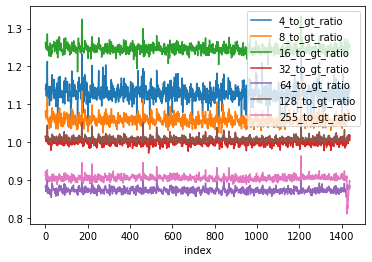

In [270]:
dff.reset_index().plot(x='index', y=["4_to_gt_ratio", "8_to_gt_ratio", "16_to_gt_ratio", "32_to_gt_ratio", "64_to_gt_ratio", "128_to_gt_ratio", "255_to_gt_ratio"])

<AxesSubplot:xlabel='index'>

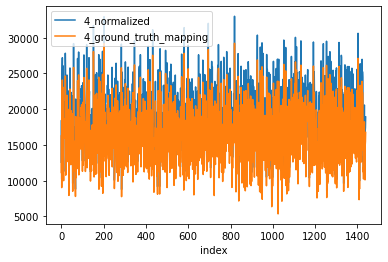

In [271]:
dff.reset_index().plot(x='index',y = ['4_normalized', '4_ground_truth_mapping'])

<AxesSubplot:xlabel='index'>

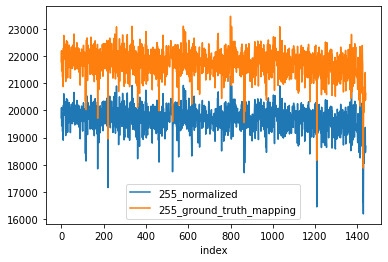

In [272]:
dff.reset_index().plot(x='index',y = ['255_normalized', '255_ground_truth_mapping'])

## 
(16_Blue) / mean(16_Blue)   = A


(16_ground_truth) / mean(16_ground_truth)   = B 


(A - B) / B 

In [273]:
new_df = pd.DataFrame()

In [274]:
new_df['4_diff'] = 100 * ((dff['4_mapping'] / dff['4_mapping'].mean()) - (dff['4_ground_truth_mapping'] / dff['4_ground_truth_mapping'].mean()))/((dff['4_ground_truth_mapping'] / dff['4_ground_truth_mapping'].mean()))
new_df['8_diff'] = 100 * ((dff['8_mapping'] / dff['8_mapping'].mean()) - (dff['8_ground_truth_mapping'] / dff['8_ground_truth_mapping'].mean()))/((dff['8_ground_truth_mapping'] / dff['8_ground_truth_mapping'].mean()))
new_df['16_diff'] = 100 * ((dff['16_mapping'] / dff['16_mapping'].mean()) - (dff['16_ground_truth_mapping'] / dff['16_ground_truth_mapping'].mean()))/((dff['16_ground_truth_mapping'] / dff['16_ground_truth_mapping'].mean()))
new_df['32_diff'] = 100 * ((dff['32_mapping'] / dff['32_mapping'].mean()) - (dff['32_ground_truth_mapping'] / dff['32_ground_truth_mapping'].mean()))/((dff['32_ground_truth_mapping'] / dff['32_ground_truth_mapping'].mean()))
new_df['64_diff'] = 100 * ((dff['64_mapping'] / dff['64_mapping'].mean()) - (dff['64_ground_truth_mapping'] / dff['64_ground_truth_mapping'].mean()))/((dff['64_ground_truth_mapping'] / dff['64_ground_truth_mapping'].mean()))
new_df['128_diff'] = 100 * ((dff['128_mapping'] / dff['128_mapping'].mean()) - (dff['128_ground_truth_mapping'] / dff['128_ground_truth_mapping'].mean()))/((dff['128_ground_truth_mapping'] / dff['128_ground_truth_mapping'].mean()))
new_df['255_diff'] = 100 * ((dff['255_mapping'] / dff['255_mapping'].mean()) - (dff['255_ground_truth_mapping'] / dff['255_ground_truth_mapping'].mean()))/((dff['255_ground_truth_mapping'] / dff['255_ground_truth_mapping'].mean()))

In [275]:
new_df['A-1_4'] = 100 * ((dff['4_mapping'] / dff['4_mapping'].mean()) - 1)
new_df['A-1_8'] = 100 * ((dff['8_mapping'] / dff['8_mapping'].mean()) - 1)
new_df['A-1_16'] = 100 * ((dff['16_mapping'] / dff['16_mapping'].mean()) - 1)
new_df['A-1_32'] = 100 * ((dff['32_mapping'] / dff['32_mapping'].mean()) - 1)
new_df['A-1_64'] = 100 * ((dff['64_mapping'] / dff['64_mapping'].mean()) - 1)
new_df['A-1_128'] = 100 * ((dff['128_mapping'] / dff['128_mapping'].mean()) - 1)
new_df['A-1_255'] = 100 * ((dff['255_mapping'] / dff['255_mapping'].mean()) - 1)

In [276]:
new_df['B-1_4'] = 100 * ((dff['4_ground_truth_mapping'] / dff['4_ground_truth_mapping'].mean()) - 1)
new_df['B-1_8'] = 100 * ((dff['8_ground_truth_mapping'] / dff['8_ground_truth_mapping'].mean()) - 1)
new_df['B-1_16'] = 100 * ((dff['16_ground_truth_mapping'] / dff['16_ground_truth_mapping'].mean()) - 1)
new_df['B-1_32'] = 100 * ((dff['32_ground_truth_mapping'] / dff['32_ground_truth_mapping'].mean()) - 1)
new_df['B-1_64'] = 100 * ((dff['64_ground_truth_mapping'] / dff['64_ground_truth_mapping'].mean()) - 1)
new_df['B-1_128'] = 100 * ((dff['128_ground_truth_mapping'] / dff['128_ground_truth_mapping'].mean()) - 1)
new_df['B-1_255'] = 100 * ((dff['255_ground_truth_mapping'] / dff['255_ground_truth_mapping'].mean()) - 1)

In [277]:
new_df

,4_diff,8_diff,16_diff,32_diff,64_diff,128_diff,255_diff,A-1_4,A-1_8,A-1_16,...,A-1_64,A-1_128,A-1_255,B-1_4,B-1_8,B-1_16,B-1_32,B-1_64,B-1_128,B-1_255
0,1.261758,2.388632,1.355489,1.439641,1.038191,0.689413,0.800865,-31.395353,-17.020826,-11.748103,...,-2.744167,-0.359630,1.026005,-32.250191,-18.956653,-12.928349,-6.559203,-3.743493,-1.041860,0.223351
1,1.417256,1.099161,0.381700,0.947045,1.506093,0.597007,1.918813,0.802203,0.857570,-1.510787,...,0.699265,2.091672,4.074007,-0.606458,-0.238965,-1.885290,-1.876788,-0.794856,1.485794,2.114618
2,2.377025,2.159051,0.355023,0.317717,-0.299007,0.471276,-0.616949,-43.797294,-24.927336,-20.163320,...,-9.518317,-3.729023,-1.894996,-45.102228,-26.513938,-20.445756,-13.957239,-9.246959,-4.180596,-1.285981
3,1.002417,1.052667,0.753408,0.813428,0.058698,0.425037,0.717419,8.028574,7.699122,3.610269,...,4.509020,3.744235,1.605125,6.956424,6.577218,2.835498,4.876175,4.447712,3.305150,0.881383
4,-0.293254,0.888183,-0.062720,0.044658,0.426932,0.462091,0.504490,36.205482,20.746017,13.890740,...,4.339948,2.601212,-0.172875,36.606085,19.683013,13.962217,7.388800,3.896381,2.129282,-0.673965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.485111,2.227590,0.306171,1.091602,0.663183,1.173385,-3.539085,-4.583845,-4.416511,-7.207242,...,-4.502516,-3.875917,-8.219599,-5.044484,-6.499322,-7.490479,-5.751735,-5.131666,-4.990742,-4.852239
1436,1.624769,1.953449,1.048303,1.535948,0.555846,0.138473,-1.823947,-37.531561,-24.775199,-17.353453,...,-12.336184,-9.457908,-8.006239,-38.530302,-26.216522,-18.210851,-15.761637,-12.820766,-9.583111,-6.297149
1437,0.423147,0.625981,0.725775,0.799068,0.819904,0.999443,-1.618595,-8.275284,-8.219934,-7.336707,...,-8.661686,-5.803907,-3.159917,-8.661779,-8.790886,-8.004388,-10.032671,-9.404482,-6.736027,-1.566680
1438,1.616101,1.447536,0.962236,1.868823,1.595251,0.698050,-0.720636,-4.448924,-4.453393,-7.571661,...,-7.309110,-7.516146,-6.903878,-5.968566,-5.816729,-8.452564,-8.593663,-8.764544,-8.157254,-6.228124


In [278]:
new_df[new_df['4_diff'] < 10]

,4_diff,8_diff,16_diff,32_diff,64_diff,128_diff,255_diff,A-1_4,A-1_8,A-1_16,...,A-1_64,A-1_128,A-1_255,B-1_4,B-1_8,B-1_16,B-1_32,B-1_64,B-1_128,B-1_255
0,1.261758,2.388632,1.355489,1.439641,1.038191,0.689413,0.800865,-31.395353,-17.020826,-11.748103,...,-2.744167,-0.359630,1.026005,-32.250191,-18.956653,-12.928349,-6.559203,-3.743493,-1.041860,0.223351
1,1.417256,1.099161,0.381700,0.947045,1.506093,0.597007,1.918813,0.802203,0.857570,-1.510787,...,0.699265,2.091672,4.074007,-0.606458,-0.238965,-1.885290,-1.876788,-0.794856,1.485794,2.114618
2,2.377025,2.159051,0.355023,0.317717,-0.299007,0.471276,-0.616949,-43.797294,-24.927336,-20.163320,...,-9.518317,-3.729023,-1.894996,-45.102228,-26.513938,-20.445756,-13.957239,-9.246959,-4.180596,-1.285981
3,1.002417,1.052667,0.753408,0.813428,0.058698,0.425037,0.717419,8.028574,7.699122,3.610269,...,4.509020,3.744235,1.605125,6.956424,6.577218,2.835498,4.876175,4.447712,3.305150,0.881383
4,-0.293254,0.888183,-0.062720,0.044658,0.426932,0.462091,0.504490,36.205482,20.746017,13.890740,...,4.339948,2.601212,-0.172875,36.606085,19.683013,13.962217,7.388800,3.896381,2.129282,-0.673965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.485111,2.227590,0.306171,1.091602,0.663183,1.173385,-3.539085,-4.583845,-4.416511,-7.207242,...,-4.502516,-3.875917,-8.219599,-5.044484,-6.499322,-7.490479,-5.751735,-5.131666,-4.990742,-4.852239
1436,1.624769,1.953449,1.048303,1.535948,0.555846,0.138473,-1.823947,-37.531561,-24.775199,-17.353453,...,-12.336184,-9.457908,-8.006239,-38.530302,-26.216522,-18.210851,-15.761637,-12.820766,-9.583111,-6.297149
1437,0.423147,0.625981,0.725775,0.799068,0.819904,0.999443,-1.618595,-8.275284,-8.219934,-7.336707,...,-8.661686,-5.803907,-3.159917,-8.661779,-8.790886,-8.004388,-10.032671,-9.404482,-6.736027,-1.566680
1438,1.616101,1.447536,0.962236,1.868823,1.595251,0.698050,-0.720636,-4.448924,-4.453393,-7.571661,...,-7.309110,-7.516146,-6.903878,-5.968566,-5.816729,-8.452564,-8.593663,-8.764544,-8.157254,-6.228124


<AxesSubplot:>

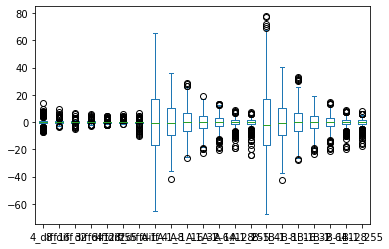

In [279]:
new_df.plot.box()

<AxesSubplot:>

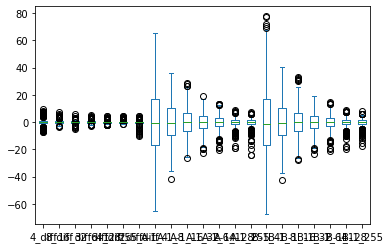

In [280]:
new_df[new_df['4_diff'] < 10].plot.box()

In [281]:
new_df[new_df['4_diff'] > 10].count()

4_diff      1
8_diff      1
16_diff     1
32_diff     1
64_diff     1
128_diff    1
255_diff    1
A-1_4       1
A-1_8       1
A-1_16      1
A-1_32      1
A-1_64      1
A-1_128     1
A-1_255     1
B-1_4       1
B-1_8       1
B-1_16      1
B-1_32      1
B-1_64      1
B-1_128     1
B-1_255     1
dtype: int64

<AxesSubplot:xlabel='index'>

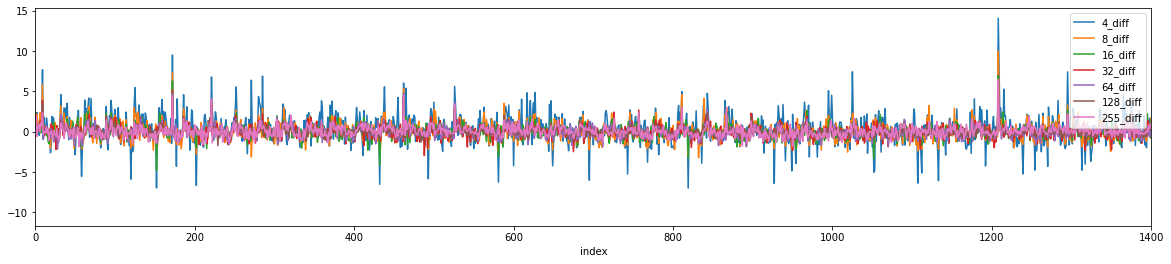

In [293]:
new_df.reset_index().plot(figsize=[20, 4],xlim=[0, 1400], x='index', y=['4_diff', '8_diff', '16_diff', '32_diff', '64_diff', '128_diff', '255_diff'])

<AxesSubplot:xlabel='index'>

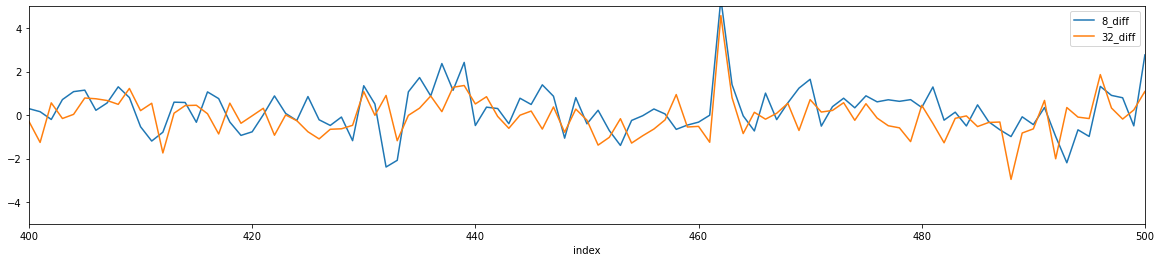

In [308]:
new_df.reset_index().plot(figsize=[20, 4],xlim=[400, 500], x='index',ylim=[-5, 5], y=['8_diff', '32_diff'])

<AxesSubplot:xlabel='index'>

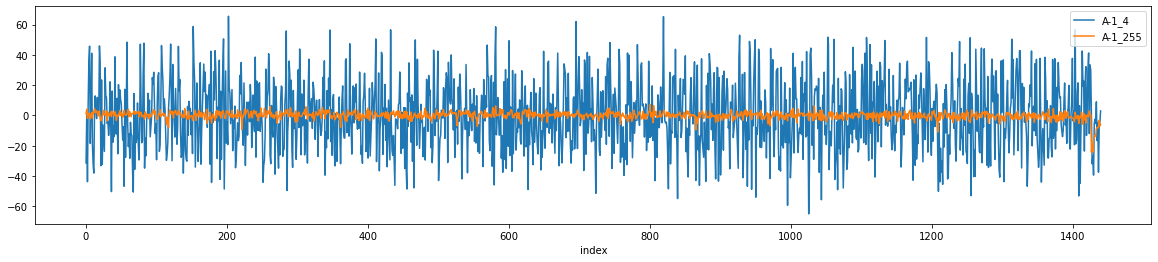

In [295]:
new_df.reset_index().plot(figsize=[20, 4], x='index', y=['A-1_4', 'A-1_255'])

<AxesSubplot:xlabel='index'>

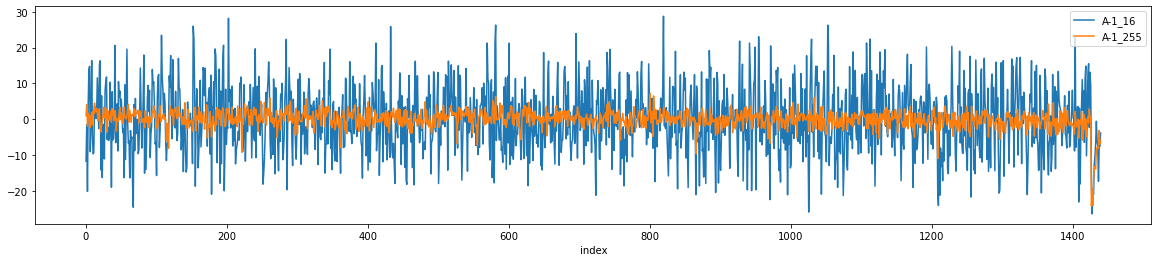

In [284]:
new_df.reset_index().plot(figsize=[20, 4], x='index', y=['A-1_16', 'A-1_255'])

<AxesSubplot:xlabel='index'>

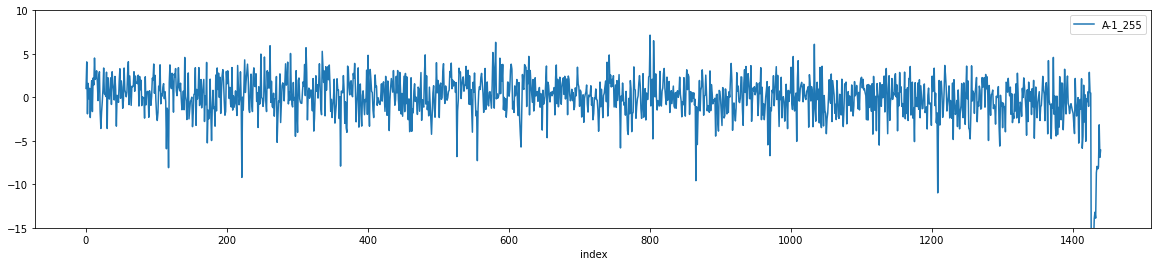

In [285]:
new_df.reset_index().plot(figsize=[20, 4], x='index', y=['A-1_255'], ylim=[-15, 10])

<AxesSubplot:xlabel='index'>

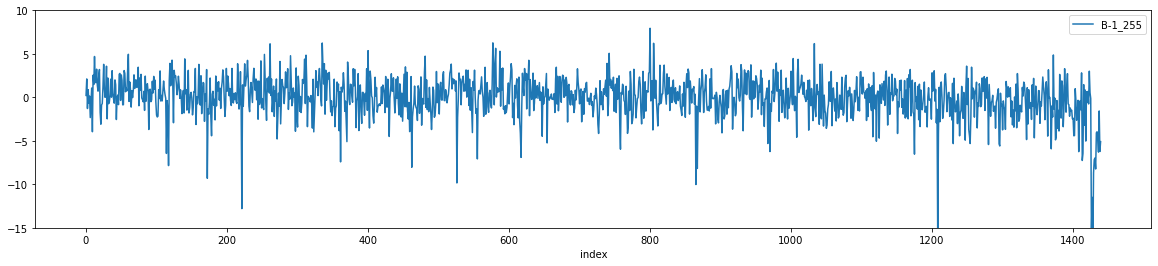

In [286]:
new_df.reset_index().plot(figsize=[20, 4], x='index', y=['B-1_255'], ylim=[-15, 10])

In [287]:
new_df[new_df['A-1_255'] > 5].count()

4_diff      9
8_diff      9
16_diff     9
32_diff     9
64_diff     9
128_diff    9
255_diff    9
A-1_4       9
A-1_8       9
A-1_16      9
A-1_32      9
A-1_64      9
A-1_128     9
A-1_255     9
B-1_4       9
B-1_8       9
B-1_16      9
B-1_32      9
B-1_64      9
B-1_128     9
B-1_255     9
dtype: int64

In [288]:
new_df[new_df['A-1_255'] < -5].count()

4_diff      35
8_diff      35
16_diff     35
32_diff     35
64_diff     35
128_diff    35
255_diff    35
A-1_4       35
A-1_8       35
A-1_16      35
A-1_32      35
A-1_64      35
A-1_128     35
A-1_255     35
B-1_4       35
B-1_8       35
B-1_16      35
B-1_32      35
B-1_64      35
B-1_128     35
B-1_255     35
dtype: int64

<AxesSubplot:xlabel='index'>

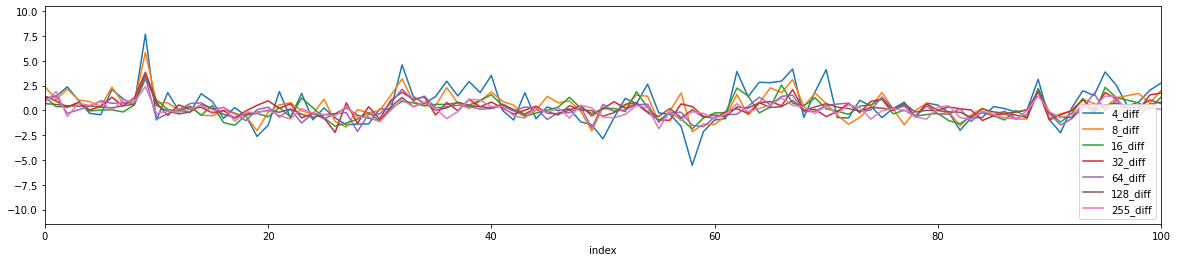

In [290]:
new_df[new_df['4_diff'] < 10].reset_index().plot(figsize=[20, 4],xlim=[0, 100], x='index', y=['4_diff', '8_diff', '16_diff', '32_diff', '64_diff', '128_diff', '255_diff'])

In [ ]:
new_df.reset_index().plot(figsize=[20, 4],xlim=[1417, 1448], x='index', y=['4_diff', '8_diff', '16_diff', '32_diff', '64_diff', '128_diff', '255_diff'])

In [131]:
dff

,4_ground_truth_mapping,8_ground_truth_mapping,16_ground_truth_mapping,32_ground_truth_mapping,64_ground_truth_mapping,128_ground_truth_mapping,255_ground_truth_mapping,4_mapping,8_mapping,16_mapping,...,128_diff_percentage,255_diff_percentage,4_normalized,8_normalized,16_normalized,32_normalized,64_normalized,128_normalized,255_normalized,test
0,13760,18592,15179,20860,19719,21452,21842,15529,19497,18799,...,1.339827,-8.81537,15815.806350,19965.724729,19095.354123,21062.970421,17349.331002,21739.419750,19916.546799,-0.015332
1,14208,18976,15634,21279,19918,21470,21778,15988,19964,19480,...,1.339827,-8.81537,16330.739580,20378.097701,19667.749282,21486.047344,17524.416801,21757.660919,19858.188636,-0.009357
2,23590,25483,19766,24571,21797,22555,22402,25705,26364,24505,...,1.339827,-8.81537,27114.452893,27365.886578,24865.852137,24810.078918,19177.613867,22857.198045,20427.180725,-0.014324
3,14472,18580,15243,20878,19525,21352,21907,16145,19846,18929,...,1.339827,-8.81537,16634.182377,19952.838073,19175.866849,21081.145564,17178.644344,21638.079923,19975.816809,-0.012685
4,13861,18309,15788,21175,20036,21800,22259,15375,19231,19613,...,1.339827,-8.81537,15931.896208,19661.814439,19861.483029,21381.035411,17628.236521,22092.082349,20296.786705,-0.012322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,16509,20521,16288,22465,20787,22143,22111,19274,22458,20757,...,1.339827,-8.81537,18975.519407,22037.254580,20490.488698,22683.587273,18288.987451,22439.677957,20161.833453,0.013200
1476,15559,19702,15592,21537,19933,21891,22559,18120,21628,19951,...,1.339827,-8.81537,17883.585102,21157.740351,19614.912806,21746.557717,17537.614223,22184.301592,20570.340594,0.017329
1477,10258,15725,14770,19657,18897,20811,21349,12483,17508,18763,...,1.339827,-8.81537,11790.591682,16886.887982,18580.827485,19848.265080,16626.112275,21089.831458,19467.006575,0.009997
1478,14119,18738,16402,21047,19469,21142,21576,17289,21055,21333,...,1.339827,-8.81537,16228.442577,20122.512369,20633.901991,21251.789955,17129.373968,21425.266286,19673.995685,0.034078


<AxesSubplot:xlabel='index'>

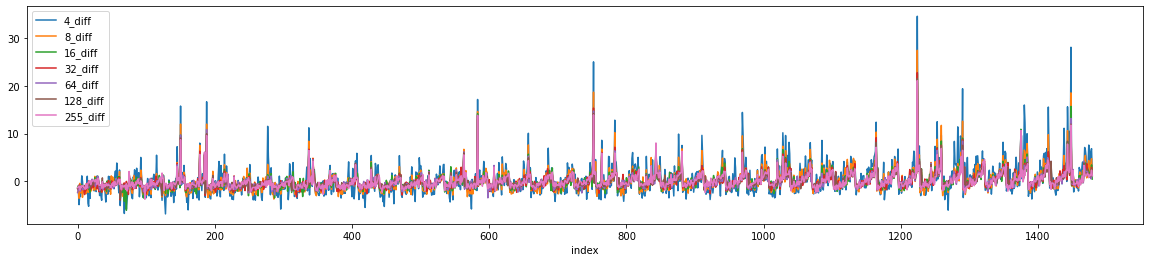

In [108]:
new_df.reset_index().plot(figsize=[20, 4], x='index', y=['4_diff', '8_diff', '16_diff', '32_diff', '64_diff', '128_diff', '255_diff'])

In [82]:
(dff['test'] * 100).mean()

0.01909679103056591

In [63]:
print ("4:   " , (dff['4_to_gt_ratio'].mean() - 1) * 100, "%")
print ("8:   " , (dff['8_to_gt_ratio'].mean() - 1) * 100, "%")
print ("16:   " , (.mean() - 1) * 100, "%")
print ("32:   " , (dff['32_to_gt_ratio'].mean() - 1) * 100, "%")
print ("64:   " , (dff['64_to_gt_ratio'].mean() - 1) * 100, "%")
print ("128:   " , (dff['128_to_gt_ratio'].mean() - 1) * 100, "%")
print ("255:   " , (dff['255_to_gt_ratio'].mean() - 1) * 100, "%")

4:    14.940453128109986 %
8:    7.388794796602327 %
16:    25.801133953888854 %
32:    0.9730125667766654 %
64:    -12.017186459151786 %
128:    1.3398272908619058 %
255:    -8.815370390652522 %


In [70]:
(((dff['16_normalized'] - dff['16_mapping']) / dff['16_mapping']))

0       0.015764
1       0.009638
2       0.014726
3       0.013042
4       0.012669
          ...   
1475   -0.012840
1476   -0.016846
1477   -0.009709
1478   -0.032771
1479   -0.003978
Length: 1480, dtype: float64

In [65]:
dff['16_to_gt_ratio']


0       1.238487
1       1.246002
2       1.239755
3       1.241816
4       1.242273
          ...   
1475    1.274374
1476    1.279566
1477    1.270345
1478    1.300634
1479    1.263036
Name: 16_to_gt_ratio, Length: 1480, dtype: float64